In [2]:
import pandas as pd

# Load CSV files
train_df = pd.read_csv("training_data.csv")
val_df = pd.read_csv("validation_data.csv")
test_df = pd.read_csv("testing_data.csv")

# Check if columns are the same
columns_match = list(train_df.columns) == list(val_df.columns) == list(test_df.columns)
print("All datasets have the same columns and order?", columns_match)

# Print column names and number of columns
print("\nColumn Names:")
print(train_df.columns.tolist())
print("\nNumber of Columns:", len(train_df.columns))

# Print number of rows in each dataset
print("\nNumber of Rows:")
print("Training Data:", len(train_df))
print("Validation Data:", len(val_df))
print("Testing Data:", len(test_df))


All datasets have the same columns and order? True

Column Names:
['date', 'open', 'high', 'low', 'close', 'volume', 'stock', 'daily_variation', 'daily_return', 'sma_7', 'std_7', 'ema_14', 'macd', 'macd_signal', 'cumulative_return', 'gain', 'loss', 'rsi', 'L14', 'H14', 'stochastic_oscillator', 'prev_high', 'prev_low', 'prev_close', 'atr', 'smoothed_plus_dm', 'smoothed_minus_dm', 'dx', 'adx', 'label_3', 'label_7', 'title', 'sentiment']

Number of Columns: 33

Number of Rows:
Training Data: 113239
Validation Data: 24271
Testing Data: 24267


In [3]:
# Check potential target columns
for col in ['label_3', 'label_7']:
    print(f"\n--- {col} ---")
    print("Unique values:", train_df[col].unique())
    print("Value counts:\n", train_df[col].value_counts())



--- label_3 ---
Unique values: ['hold' 'buy' 'sell']
Value counts:
 label_3
hold    85371
buy     15021
sell    12847
Name: count, dtype: int64

--- label_7 ---
Unique values: ['hold' 'sell' 'buy']
Value counts:
 label_7
hold    75547
buy     20855
sell    16837
Name: count, dtype: int64


In [5]:
# stratified split check
def print_label_distribution(df, name):
    counts = df['label_3'].value_counts(normalize=True) * 100
    print(f"\n{name} Label Distribution (%):")
    print(counts.sort_index())  # Sorted for consistent comparison

print_label_distribution(train_df, "Training")
print_label_distribution(val_df, "Validation")
print_label_distribution(test_df, "Testing")



Training Label Distribution (%):
label_3
buy     13.264865
hold    75.390104
sell    11.345031
Name: proportion, dtype: float64

Validation Label Distribution (%):
label_3
buy     13.106176
hold    75.423345
sell    11.470479
Name: proportion, dtype: float64

Testing Label Distribution (%):
label_3
buy     13.644043
hold    75.023695
sell    11.332262
Name: proportion, dtype: float64


# Primitive Baseline

In [10]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def baseline_xgboost(df, target_column='label_3', drop_cols=None, test_size=0.15, random_state=42):
    """
    Trains an XGBoost model on a given DataFrame.

    Args:
        df (pd.DataFrame): The full dataset.
        target_column (str): The name of the target column.
        drop_cols (list): Columns to drop before training.
        test_size (float): Fraction of data to use for validation.
        random_state (int): Seed for reproducibility.

    Returns:
        model (xgb.XGBClassifier): Trained XGBoost model.
        le (LabelEncoder): Fitted label encoder.
        X_train, X_val, y_train, y_val: Split features and labels.
    """
    if drop_cols is None:
        drop_cols = ['label_7', 'title', 'date', 'stock']

    # Encode target
    le = LabelEncoder()
    y = le.fit_transform(df[target_column])

    # Features
    X = df.drop(drop_cols + [target_column], axis=1)

    # Train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Model setup
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_),
        eval_metric='mlogloss',
        random_state=random_state
    )

    # Train
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

    return model, le, X_train, X_val, y_train, y_val


In [11]:
# Load the dataset
training_data = pd.read_csv("training_data.csv")

# Train the model
baseline_model, le, X_train, X_val, y_train, y_val = baseline_xgboost(training_data)


[0]	validation_0-mlogloss:0.92561
[1]	validation_0-mlogloss:0.82687
[2]	validation_0-mlogloss:0.76655
[3]	validation_0-mlogloss:0.72860
[4]	validation_0-mlogloss:0.70451
[5]	validation_0-mlogloss:0.68857
[6]	validation_0-mlogloss:0.67785
[7]	validation_0-mlogloss:0.66991
[8]	validation_0-mlogloss:0.66401
[9]	validation_0-mlogloss:0.65881
[10]	validation_0-mlogloss:0.65484
[11]	validation_0-mlogloss:0.65118
[12]	validation_0-mlogloss:0.64743
[13]	validation_0-mlogloss:0.64418
[14]	validation_0-mlogloss:0.64175
[15]	validation_0-mlogloss:0.63905
[16]	validation_0-mlogloss:0.63710
[17]	validation_0-mlogloss:0.63391
[18]	validation_0-mlogloss:0.63107
[19]	validation_0-mlogloss:0.62869
[20]	validation_0-mlogloss:0.62732
[21]	validation_0-mlogloss:0.62473
[22]	validation_0-mlogloss:0.62343
[23]	validation_0-mlogloss:0.62099
[24]	validation_0-mlogloss:0.61826
[25]	validation_0-mlogloss:0.61599
[26]	validation_0-mlogloss:0.61401
[27]	validation_0-mlogloss:0.61219
[28]	validation_0-mlogloss:0.6

Classification Report:
              precision    recall  f1-score   support

         buy       0.89      0.27      0.41      3311
        hold       0.80      1.00      0.89     18206
        sell       0.94      0.24      0.39      2750

    accuracy                           0.81     24267
   macro avg       0.88      0.50      0.56     24267
weighted avg       0.83      0.81      0.77     24267



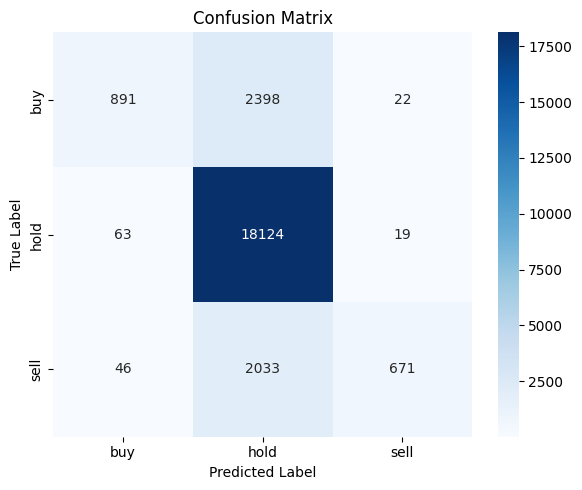

In [14]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load test data
test_data = pd.read_csv("testing_data.csv")

# Prepare features and true labels
drop_cols = ['label_7', 'title', 'date', 'stock']
X_test = test_data.drop(drop_cols + ['label_3'], axis=1)
y_test = le.transform(test_data['label_3'])  # use the SAME encoder

# Predict using the trained model
y_pred = baseline_model.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_  # ['buy', 'hold', 'sell']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Baseline Model Summary
- Primitve model achieves an overall 81% accuracy, but this is largely driven by the dominance of the "hold" class in the dataset
- While precision is high across all classes, recall is very low for the "buy" and "sell" classes -> model struggles to detect them
- The macro average F1-score is only 0.56 -> imbalanced performance across classes
- Most "buy" and "sell" instances are misclassified as "hold", which inflates the accuracy but reduces the model's usefulness for decision making

# Grid Search

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

def gridsearch_xgboost(df, target_column='label_3', drop_cols=None, param_grid=None, cv=3, scoring='f1_macro'):
    """
    Perform grid search with 3-fold CV on XGBoost for a given DataFrame.

    Args:
        df (pd.DataFrame): The full dataset.
        target_column (str): Name of the label column.
        drop_cols (list): List of non-feature columns to drop.
        param_grid (dict): Hyperparameters to search.
        cv (int): Number of folds for cross-validation.
        scoring (str): Scoring metric.

    Returns:
        best_model: Trained best XGBoost model.
        grid_search: Full GridSearchCV object (for inspection).
    """
    if drop_cols is None:
        drop_cols = ['label_7', 'title', 'date', 'stock']

    if param_grid is None:
        param_grid = {
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.3],
            'n_estimators': [50, 100],
            'subsample': [0.8, 1.0]
        }

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(df[target_column])
    X = df.drop(drop_cols + [target_column], axis=1)

    # XGBoost model
    xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=42)

    # Grid search
    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=1,
        n_jobs=-1  # parallelize
    )

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    return best_model, grid_search


In [16]:
training_data = pd.read_csv("training_data.csv")

best_model, grid_search = gridsearch_xgboost(training_data)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Params: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV Score: 0.49666421445121856


Classification Report:
              precision    recall  f1-score   support

         buy       0.85      0.19      0.32      3311
        hold       0.79      0.99      0.88     18206
        sell       0.91      0.17      0.28      2750

    accuracy                           0.79     24267
   macro avg       0.85      0.45      0.49     24267
weighted avg       0.81      0.79      0.73     24267



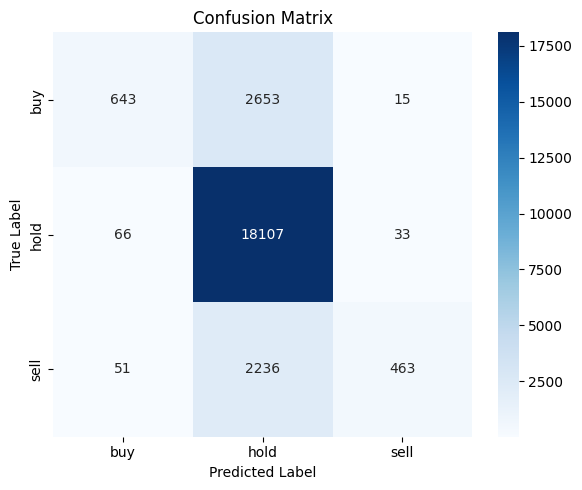

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the test set
test_data = pd.read_csv("testing_data.csv")

# Prepare features and labels
drop_cols = ['label_7', 'title', 'date', 'stock']
X_test = test_data.drop(drop_cols + ['label_3'], axis=1)
y_test = le.transform(test_data['label_3'])  # same encoder from training

# Predict using the best model from grid search
y_pred = best_model.predict(X_test)

# Print performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix (pretty)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Grid Search Summary
- Results got worst. It seems like we have to address the class imbalance before tackling grid/ optimization

# Class Imbalance
- inverse frequency weighting

In [19]:
import numpy as np
from xgboost import XGBClassifier

# compute class weights (balanced weighting)
class_counts = np.bincount(y_train)  # y_train must be label-encoded (0, 1, 2)
total_samples = len(y_train)
n_classes = len(class_counts)

# Inverse frequency weight: total / (classes × class_count)
class_weights = total_samples / (n_classes * class_counts)
sample_weights = class_weights[y_train]  # Row-wise weights for each training sample

# Train the model
weighted_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42
)

weighted_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=True
)


[0]	validation_0-mlogloss:1.08921
[1]	validation_0-mlogloss:1.08075
[2]	validation_0-mlogloss:1.07339
[3]	validation_0-mlogloss:1.06648
[4]	validation_0-mlogloss:1.06035
[5]	validation_0-mlogloss:1.05469
[6]	validation_0-mlogloss:1.04959
[7]	validation_0-mlogloss:1.04495
[8]	validation_0-mlogloss:1.04048
[9]	validation_0-mlogloss:1.03661
[10]	validation_0-mlogloss:1.03271
[11]	validation_0-mlogloss:1.02932
[12]	validation_0-mlogloss:1.02656
[13]	validation_0-mlogloss:1.02342
[14]	validation_0-mlogloss:1.02078
[15]	validation_0-mlogloss:1.01786
[16]	validation_0-mlogloss:1.01515
[17]	validation_0-mlogloss:1.01269
[18]	validation_0-mlogloss:1.01029
[19]	validation_0-mlogloss:1.00822
[20]	validation_0-mlogloss:1.00612
[21]	validation_0-mlogloss:1.00396
[22]	validation_0-mlogloss:1.00209
[23]	validation_0-mlogloss:1.00052
[24]	validation_0-mlogloss:0.99872
[25]	validation_0-mlogloss:0.99705
[26]	validation_0-mlogloss:0.99562
[27]	validation_0-mlogloss:0.99416
[28]	validation_0-mlogloss:0.9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

Classification Report:
              precision    recall  f1-score   support

         buy       0.35      0.58      0.44      3311
        hold       0.88      0.69      0.77     18206
        sell       0.32      0.54      0.41      2750

    accuracy                           0.66     24267
   macro avg       0.52      0.60      0.54     24267
weighted avg       0.75      0.66      0.69     24267



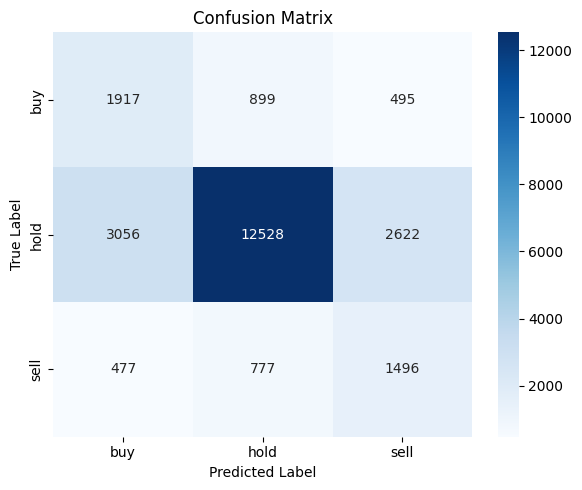

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the test set
test_data = pd.read_csv("testing_data.csv")

# Prepare features and labels
drop_cols = ['label_7', 'title', 'date', 'stock']
X_test = test_data.drop(drop_cols + ['label_3'], axis=1)
y_test = le.transform(test_data['label_3'])  # same encoder from training

# Predict using the best model from grid search
y_pred = weighted_model.predict(X_test)

# Print performance
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix (pretty)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Weighted Model Summary
- Inverse class weight seems to be working as recall improves for minority class. "Buy" rising from 19%->58% and "sell" from 17%->54%
- Overall accuracy dropped to 66% but this maybe an acceptable tradeoff?
- Macro F1-score improved to 0.54 -> better balance across all classes
Model no longer over-relies on predicting "hold" -> more capable of detecting actionable signals
- Model is more "fair"
## Posible next steps
- Focused Grid Search with weighted model
- softprob to emphasize "buy/hold"
- SMOTE, feature importance (low priority)

# Optuna + Weighted Model
- Intuition: Imbalance is largely solved, tightening tree parameters should be done first before re-balancing again
- Optuna maybe better thatn GridSearchCV. Since it is Bayesian (need further research)

In [24]:
#!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.3 MB/s eta 0:00:00


In [ ]:
# runs 200 bayesian trials to find best max_depth, learning_rate, n_estimators, and subsample
# after each trial, measure the performance with the macro-average F1-score on the validation set aka "value"
# and keeps track of the best-scoring parameter combination

import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def objective(trial):
    params = {
        'max_depth':        trial.suggest_int('max_depth', 3, 10),
        'learning_rate':    trial.suggest_float('lr', 0.01, 0.3, log=True),
        'n_estimators':     trial.suggest_int('n_estimators', 100, 600, step=50),
        'subsample':        trial.suggest_float('subsample', 0.6, 1.0),
        'objective':        'multi:softprob',
        'num_class':        3,
        'eval_metric':      'mlogloss',
        'random_state':     42
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)          # 200 trials
print(study.best_params, study.best_value)


[I 2025-05-19 13:12:10,532] A new study created in memory with name: no-name-2c72660c-1ccc-42e4-897a-c1dc60987f15
[I 2025-05-19 13:14:19,974] Trial 0 finished with value: 0.8319640664504346 and parameters: {'max_depth': 10, 'lr': 0.07880927833638944, 'n_estimators': 500, 'subsample': 0.8482541814138929}. Best is trial 0 with value: 0.8319640664504346.
[I 2025-05-19 13:14:48,655] Trial 1 finished with value: 0.5248876152801242 and parameters: {'max_depth': 4, 'lr': 0.06325246248430526, 'n_estimators': 500, 'subsample': 0.6875757157020473}. Best is trial 0 with value: 0.8319640664504346.
[I 2025-05-19 13:15:36,990] Trial 2 finished with value: 0.487687020478109 and parameters: {'max_depth': 5, 'lr': 0.011995134573282943, 'n_estimators': 600, 'subsample': 0.7941965782126048}. Best is trial 0 with value: 0.8319640664504346.
[I 2025-05-19 13:16:15,634] Trial 3 finished with value: 0.5484400539186859 and parameters: {'max_depth': 5, 'lr': 0.0398025037404503, 'n_estimators': 500, 'subsample':